In [261]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error



In [262]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [263]:
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)
    
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [264]:
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # LSTM Layer: Bidirectional for richer context
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout_rate, 
                            bidirectional=True)
        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
        out = self.fc1(out)  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(out)  # Nonlinear activation
        out = self.fc2(out)  # Second fully connected layer
        out = self.dropout2(out)
        out = torch.relu(out)  # Nonlinear activation
        out = self.fc3(out)  # Output layer
        return out

In [265]:
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 25

In [266]:
df = pd.read_csv('SPY.csv')
df.shape

(8020, 11)

<span style="color: yellow; font-size: 40px;">Original LSTM</span>

In [267]:
# Convert the "Date" column to datetime
df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# Sort the data by date in ascending order
df = df.sort_values(by="Date")

# Get the earliest and latest dates
earliest_date = df["Date"].min()
latest_date = df["Date"].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 1993-01-29 00:00:00
Latest Date: 2024-12-04 00:00:00


In [268]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)

df = df.dropna()


In [269]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [270]:
feature_columns = ["Open", "High", "Low", "Close", "Volume"]  

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [271]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [272]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 32
num_layers = 2
dropout_rate = 0.3
learning_rate = 0.01
num_epochs = 100
patience = 10

# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
original_lstm = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

LSTM_model_file = './models/best_lstm_model.pth'

original_lstm.load_state_dict(torch.load(LSTM_model_file))

# criterion = nn.MSELoss()

# original_lstm.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = original_lstm(X_batch)
#         loss = criterion(outputs, y_batch)
#         test_loss += loss.item() * X_batch.size(0)

# test_loss /= len(test_loader.dataset)
# print(f'Test Loss: {test_loss:.4f}')

# # Calculate Mean Absolute Error (MAE)
# test_mae = 0.0
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = original_lstm(X_batch)
#         mae = torch.mean(torch.abs(outputs - y_batch))
#         test_mae += mae.item() * X_batch.size(0)

# test_mae /= len(test_loader.dataset)
# print(f'Test MAE: {test_mae:.4f}')

original_lstm.eval()

X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)
outputs = original_lstm(X_seq_tensor)



C:\Users\ROG\AppData\Local\Temp/ipykernel_12348/1133383987.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_lstm.load_state_dict(torch.load(LSTM_model_file))


In [273]:
error = 0
largest_error = 0
less_than_actual = 0
more_than_actual = 0

for true, pred in zip(y_seq, outputs):
    percent = abs(true - pred) / true
    if percent > largest_error:
        largest_error = percent
    error += percent
    if pred < true:
        less_than_actual += 1
    else:
        more_than_actual += 1
error = error / len(y_seq)
error = error.item()
largest_error = largest_error.item()
print(f"Average error percentage: {error*100}")
print(f"Largest error percentage: {largest_error*100}")
print(f"Less than actual: {less_than_actual}")
print(f"More than actual: {more_than_actual}")


Average error percentage: 5.263708159327507
Largest error percentage: 27.914804220199585
Less than actual: 2704
More than actual: 5290


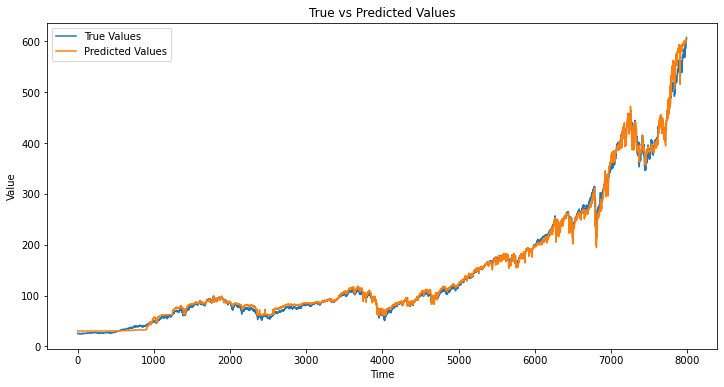

In [274]:
plt.figure(figsize=(12, 6))
plt.plot(y_seq, label='True Values')
plt.plot(outputs.detach().numpy(), label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

<span style="color: yellow; font-size: 40px;">Autoencoder</span>

In [275]:
X = df

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

In [276]:
X_train_val, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.25, random_state=42)

In [277]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
X_scaled = X_scaled.values

In [278]:
input_dim = X_train.shape[1]
encoding_dim = 8

In [279]:
encoder_model_file = './models/encoder.pth'
decoder_model_file = './models/decoder.pth'

In [280]:
if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
    print("Loading existing models...")
    encoder = Encoder(input_dim, encoding_dim).to(device)
    decoder = Decoder(encoding_dim, input_dim).to(device)
    encoder.load_state_dict(torch.load(encoder_model_file))
    decoder.load_state_dict(torch.load(decoder_model_file))
else:
    print("Some models are missing")
    

Loading existing models...


C:\Users\ROG\AppData\Local\Temp/ipykernel_12348/3102932148.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_model_file))
C:\Use

In [281]:
autoencoder = Autoencoder(encoder, decoder).to(device)
autoencoder.eval()

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=64, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=128, out_features=5, bias=True)
    )
  )
)

In [282]:
# Calculate reconstruction error on the train set
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(X_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate Mean Squared Error (MSE)
mse = np.mean((X_scaled - reconstructed_test) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(X_scaled - reconstructed_test))
print(f'Mean Absolute Error (MAE): {mae}')

reconstruction_error_percentage = (
    np.mean(np.abs(X_scaled - reconstructed_test) / (np.abs(X_scaled) + 1e-8), axis=1) * 100
)
reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean}')

def calculate_index_error_percentage(index, X, reconstructed_X):
    print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)

Mean Squared Error (MSE): 0.000393898925208361
Mean Absolute Error (MAE): 0.013584979295197346
Reconstruction Error Percentage: 7.316429470988849


In [283]:
print("Number of data points with reconstruction error percentage greater than the mean:", np.sum(reconstruction_error_percentage > reconstruction_error_percentage_mean))

Number of data points with reconstruction error percentage greater than the mean: 989


<span style="color: yellow; font-size: 40px;">Improving the LSTM using the autoencoder</span>

In [284]:
import torch.nn.functional as F

In [285]:
# Ensure outputs is detached from the computation graph and converted to numpy
predicted_values = outputs.detach().numpy()

predicted_values.shape

(7994, 1)

In [286]:
# df['predictions'] = np.nan

# # Assign the predicted values starting at index 24
# df.loc[25:, 'predictions'] = predicted_values

In [287]:
# convert reconstruction percentage to a separate dataframe
new_df = pd.DataFrame(reconstruction_error_percentage, columns=['reconstruction_error_percentage'], index=df.index)

In [288]:
new_df['target'] = df['Target']

new_df['predictions'] = np.nan
new_df.loc[25:, 'predictions'] = predicted_values

In [289]:
new_df = new_df.dropna()

In [290]:
new_df['bias'] = new_df['target'] - new_df['predictions']

In [291]:
class BiasPredictor(nn.Module):
    def __init__(self):
        super(BiasPredictor, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return self.fc7(x)

In [292]:
def train_bias_predictor(features, target_bias, val_features, val_target_bias, epochs=1000, learning_rate=0.0001, patience=10):
    model = BiasPredictor().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter for early stopping
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        loss = criterion(predictions, target_bias)
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_features).squeeze()
            val_loss = criterion(val_predictions, val_target_bias)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save the best model state
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [293]:
# X = new_df['reconstruction_error_percentage'].values.reshape(-1, 1)
X = new_df
y = new_df['bias'].values

# train val test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [294]:
bias_predictor_path = './models/bias_predictor.pth'

# X_train X_val and X_test are the dataframes that contains other columns. In the actual training process we just 
# want to use the reconstruction error percentage column, hence we will extract that column and convert it to a tensor

if not os.path.exists(bias_predictor_path):
    bias_predictor = train_bias_predictor(torch.tensor(X_train['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device), 
                                          torch.tensor(y_train, dtype=torch.float32).to(device),
                                          torch.tensor(X_val['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device),
                                          torch.tensor(y_val, dtype=torch.float32).to(device),
                                          epochs=1000, learning_rate=0.0001, patience=30)
else:
    bias_predictor = BiasPredictor().to(device)
    bias_predictor.load_state_dict(torch.load(bias_predictor_path))

C:\Users\ROG\AppData\Local\Temp/ipykernel_12348/2873719968.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bias_predictor.load_state_dict(torch.load(bias_predictor_path

In [295]:
new_df['prediction_error_percentage'] = np.nan
new_df['prediction_error_percentage'] = (abs(new_df['bias']) / new_df['target']) * 100

In [296]:
features = torch.tensor(X_test['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device)
predictions = bias_predictor(features).squeeze().cpu().detach().numpy()
# get a dataframe with predictions and y_test
predictions_df = pd.DataFrame({'predictions': predictions, 'target': y_test})

In [297]:
new_df

,reconstruction_error_percentage,target,predictions,bias,prediction_error_percentage
25,0.896283,25.536263,30.189331,-4.653069,18.221416
26,0.884764,25.588764,30.200800,-4.612036,18.023675
27,0.886637,25.518764,30.212198,-4.693434,18.392089
28,0.884935,25.256208,30.215326,-4.959118,19.635243
29,0.888870,25.378731,30.219229,-4.840498,19.073050
...,...,...,...,...,...
8014,3.770355,598.830017,602.812317,-3.982300,0.665013
8015,1.781509,602.549988,602.799622,-0.249634,0.041430
8016,1.437670,603.630005,603.611267,0.018738,0.003104
8017,1.594694,603.909973,604.112671,-0.202698,0.033564


In [298]:
X_test['predicted_bias'] = np.nan
X_test['predicted_bias'] = predictions

In [299]:
X_test

,reconstruction_error_percentage,target,predictions,bias,predicted_bias
5512,13.543988,173.354996,159.807968,13.547028,-0.264023
2602,1.237937,64.717033,72.199799,-7.482765,-2.305479
3717,4.863548,109.204933,116.526817,-7.321884,-0.525501
5943,9.320442,190.405441,189.690338,0.715103,-0.233667
7586,1.417345,382.015167,381.984253,0.030914,-1.884233
...,...,...,...,...,...
1104,0.637859,55.394333,60.121960,-4.727627,-3.219310
6597,3.553059,266.070496,261.179352,4.891144,-0.912078
1140,0.670563,59.038425,62.069733,-3.031307,-3.827935
4772,7.391907,102.384338,106.766327,-4.381989,-0.236776


In [300]:
X_test['new_predictions'] = X_test['predictions'] + X_test['predicted_bias']

In [301]:
X_test['original_error_percentage'] = (abs(X_test['bias']) / X_test['target']) * 100
X_test['new_error_percentage'] = (abs(X_test['target'] - X_test['new_predictions']) / X_test['target']) * 100

In [302]:
X_test.describe()

,reconstruction_error_percentage,target,predictions,bias,predicted_bias,new_predictions,original_error_percentage,new_error_percentage
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.945348,150.227941,152.098823,-1.870882,-1.748935,150.349888,5.393441,4.301307
std,119.733596,127.528666,128.335646,8.132307,1.067111,128.772264,4.885685,4.605802
min,0.301505,24.425903,30.152510,-53.426819,-5.344190,26.263754,0.001637,0.002000
25%,0.882345,70.081829,76.376514,-5.328647,-2.558269,74.034193,1.687993,1.585722
50%,2.133298,94.236443,94.972519,-2.516998,-1.899035,93.395638,3.797273,3.100224
75%,4.383407,189.500076,190.967796,1.674228,-0.700158,190.203516,7.630141,5.175701
max,4490.963057,603.909973,604.112671,36.173767,-0.203443,601.622487,23.538514,29.021486


In [303]:
torch.save(bias_predictor.state_dict(), bias_predictor_path)